# Introduction to digital signal processing

Speech is the primary way humans communicate using **sound**. Speech is a **continuous signal** that unfolds over time and that is shaped by the movement of our articulatory organs such as the lips, tongue, and vocal cords.

From a physical perspective, spoken words are **pressure waves** that usually travel through the air. These sound waves vary in **frequency** (related to pitch) and **amplitude** (related to loudness). The complexity of these variations carries the rich information of human language.

To analyse and process speech computationally, we must convert these continuous acoustic signals into a form that reveals their structure To this end, we use various processing techniques that are introduced in this notebook.

1. **Fast Fourier Transform (FFT)**: breaks down the signal into its frequency components
2. **Mel-frequency scaling**: scales the frequency components to the Mel-scale, which reflects how humans perceive pitch
3. **Filterbanks**: transform the signal into mel-frequency coefficients that represent the sound signal using short numerical vectors

Techniques of digital signal processing pave the way for training automated speech recognition models such as Whisper.

## Requirements

In [1]:
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

We start with an audio signal ...

In [2]:
spectrogram, srSpectrogram = librosa.load("./data/spectrogram.wav", sr=None)
display(ipyd.Audio(data=spectrogram, rate=srSpectrogram))

... that is represented with a huge array ...

In [3]:
spectrogram.shape

(71552,)

and we transform it into Mel-Frequency Cepstral Coefficients, representing our audio using a few and smart acoustic features

In [4]:
mfccs = librosa.feature.mfcc(y=spectrogram, sr=srSpectrogram, n_mfcc=13)
mfccs.shape

(13, 140)

Eventually, what the machine 'hears' sounds similar to this:

In [5]:
reconstructed_audio = librosa.feature.inverse.mfcc_to_audio(mfccs, sr=srSpectrogram)
ipyd.Audio(reconstructed_audio, rate=srSpectrogram)

We still understand the word, which already indicates that we humans rely on a few features to discriminate words. So how do we prepocess the signal so that these important features are maintained?

## The Fast Fourier Transform (FFT)

The FFT is an algorithm that transforms the speech signal, consisting of multiple samples in the time domain, into its frequency components. For starters, let us understand a simple audio signal. It is defined by its frequency, its duration, and its sampling rate (i.e. how often per second samples are taken)

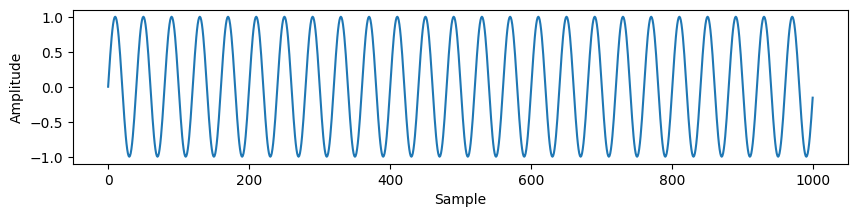

In [6]:
# Generate, visualise and play a sound with custom frequency and duration

def make_audio(duration=2, sampling_rate=16000, frequency=100, print=True):
    # Create the samples
    N = duration*sampling_rate # number of samples for given duration
    n = np.arange(N) # sample indices
    audio=np.sin(2*np.pi*(frequency/sampling_rate)*n) # generate sine wave

    # Visualise the first thousand samples
    if print:
        plt.figure(figsize=(10, 2))
        plt.plot(n[:1000], audio[:1000])
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.show()

    # Play the sound
    return audio

# Customise the sound's parameters
duration = 2 # duration in seconds
sampling_rate = 16000 # sampling rate
frequency = 400 # frequency in Hertz (Hz)


# Generate, visualise and play the sound
audio = make_audio(duration=duration, sampling_rate=sampling_rate, frequency=frequency, print=True)
ipyd.Audio(rate=sampling_rate, data=audio)

The FFT is an algorithm that breaks down a signal into its constituent frequencies. If we apply the FFT to our audio signal, we will see its frequency components. For applying the FFT, we need to specify an audio and its sampling rate.

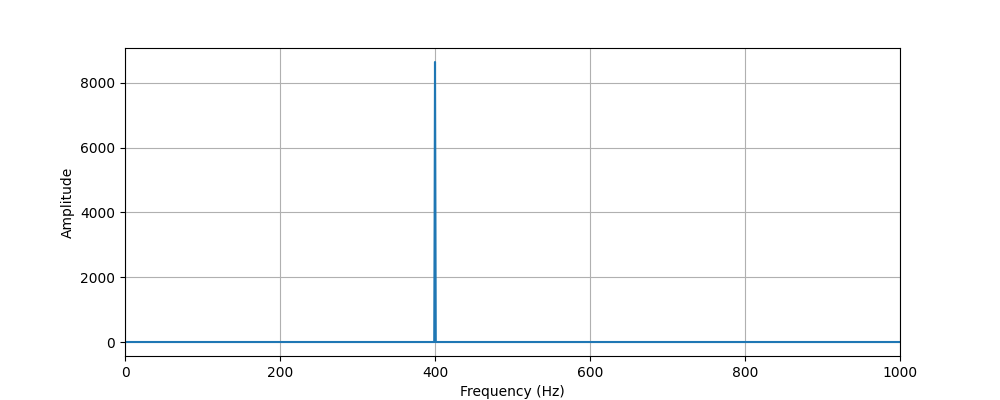

In [57]:
def apply_fft(audio, sampling_rate=16000, logscale=False, windowing=True):
    # Apply FFT
    N = len(audio)
    w = np.hamming(N)
    if windowing:
        audioFFT = np.fft.fft(audio*w)
    else:
        audioFFT = np.fft.fft(audio)
    
    # Plot spectrum
    plt.figure(figsize=(10, 4))
    if logscale:
        plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N), np.log(np.abs(audioFFT)))
    else:
        plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N), np.abs(audioFFT))
    plt.grid(True)
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1000)
    
    return plt

plt = apply_fft(audio=audio, sampling_rate=sampling_rate, logscale=False, windowing=True)
plt.show()

### Illustration of the FFT

In this section, we walk through a few examples, illustrating the nature of audio signals. First, we synthesise a A minor chord, which consists of the notes A (110 Hz, 220 Hz, 440 Hz etc. ), C (130.81 Hz, 261.63 Hz, 523.25 Hz, etc.), and E (164.81 Hz, 329.63 Hz, 659.25  Hz etc.). There are multiple frequencies for each note because notes can be playes in different octaves.

#### Synthesised A minor chord

In [8]:
A_FQ = [110, 220, 440]
C_FQ = [130, 261, 523]
E_FQ = [164, 330, 659]

octave = 1

# synthesise the fate motif
A = make_audio(duration=2, sampling_rate=sampling_rate, frequency=A_FQ[octave], print=False)
C = make_audio(duration=2, sampling_rate=sampling_rate, frequency=C_FQ[octave], print=False)
E = make_audio(duration=2, sampling_rate=sampling_rate, frequency=E_FQ[octave], print=False)
AminorSynth = A + C + E
ipyd.Audio(rate=sampling_rate, data=AminorSynth)

The FFT helps us to break down the frequency content of the A minor chord.

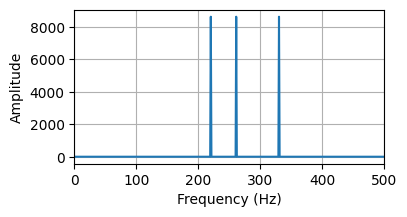

In [9]:
# investigate the fate motifs frequency components.
plt = apply_fft(audio=AminorSynth, sampling_rate=sampling_rate)
plt.xlim(0, 500)
plt.show()

#### Natural A minor chord

However, natural sound is more complex than pure tones for a number of reasons:

1. In the context of music, instruments produce rich harmonic content. That is, a single note on an instrument produces a sine wave at its fundamental frequency (e.g., 110 Hz for A), but also at its overtones (e.g., 220 Hz, 440 Hz).
2. The environment produces reflections and filtering effects of specific frequencies.
3. Natural sound have transient onsets, vibrato and natural fluctiations, which are especially important for speech sounds

In [10]:
# load and play a recording from the New York Philharmonic Orchestra
naturalAminor, srNatural = librosa.load("./data/guitar_chord_a_minor.wav", sr=None)

# only keep audio from second 3 to 5
naturalAminor = naturalAminor[3*srNatural:5*srNatural]
ipyd.Audio(data=naturalAminor, rate=srNatural)

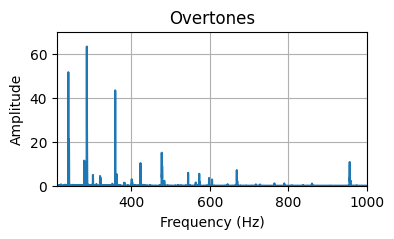

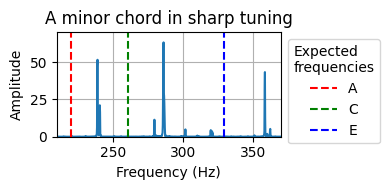

In [11]:
# visualise overtones
plt = apply_fft(audio=naturalAminor, sampling_rate=sampling_rate)
plt.xlim(210, 1000)
plt.ylim(0, 70)
plt.title("Overtones")
plt.show()

# visualise human tuning (this guitar is in sharp tuning so that the observed frequencies are higher than the expected ones)
plt = apply_fft(audio=naturalAminor, sampling_rate=sampling_rate)
plt.xlim(210, 370)
plt.ylim(0, 70)
plt.title("A minor chord in sharp tuning")
plt.axvline(x=220, color='r', linestyle='--', label="A")
plt.axvline(x=261, color='g', linestyle='--', label="C")
plt.axvline(x=329.63, color='b', linestyle='--', label="E")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Expected\nfrequencies")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### Speech sounds

Speech consists of a series of sounds that are combined to form words. Next, we consider a vowel, which is called Schwa. Schwa is common vowel sound in German and English. It can be found in German words such as *b**e**reit* (ready) and *viel**e*** (many) or English words such as ***a**bout*.

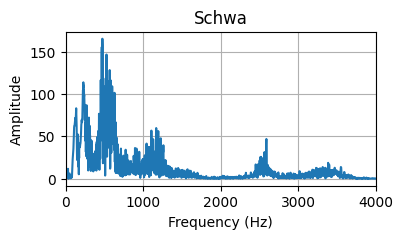

In [12]:
schwa, srSchwa= librosa.load("./data/Schwa.ogg.mp3", sr=None)

plt = apply_fft(audio=schwa, sampling_rate=srSchwa)
plt.xlim(0,4000)
plt.title("Schwa")
plt.show()

ipyd.Audio(data=schwa, rate=srSchwa)

When creating our acoustic features for training an ASR model, we make use of our knowledge about human perception. Two aspectes of human perception are especially relevant for ASR engineers:

1. The full range of human hearing is from 20 Hz to 20,000 Hz but humans hear most accurately and sensitively in a narrower range from ~ 500 Hz to 4,000 Hz. Consequently, frequencies higher than 4,000 Hz can be ignored.
2. Humans are more sensitive to changes of soft sounds (low amplitudes) than to changes of loud sounds (high amplitude). For instance, we perceive two cars driving by louder than one car driving by, but we cannot hear a difference between 100 or 102 cars driving by.

Because of how humans perceive sound, we cut off our signal at 4,000 Hz (higher frequencies are irrelevant) and we log-transform the frequency components (emphasising changes on low amplitude areas).

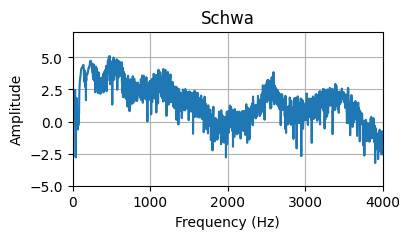

In [13]:
plt = apply_fft(audio=schwa, sampling_rate=srSchwa, logscale=True) # note that logscale has been set to True
plt.xlim(0,4000)
plt.ylim(-5, 7)
plt.title("Schwa")
plt.show()

A closer inspection of more speech sounds reveals that each sound has its own characteristic frequency spectrum.

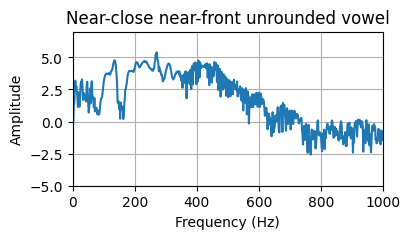

In [14]:
vowel1, srVowel1= librosa.load("./data/Near-close_near-front_unrounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel1, sampling_rate=srVowel1, logscale=True)
plt.ylim(-5, 7)
plt.title("Near-close near-front unrounded vowel")
plt.show()

ipyd.Audio(data=vowel1, rate=srVowel1)

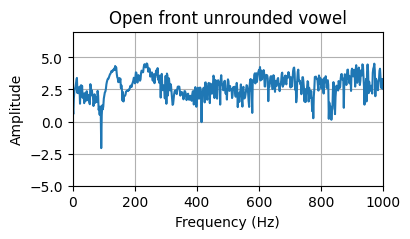

In [15]:
vowel2, srVowel2 = librosa.load("./data/Open_front_unrounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel2, sampling_rate=srVowel2, logscale=True)
plt.ylim(-5, 7)
plt.title("Open front unrounded vowel")
plt.show()

ipyd.Audio(data=vowel2, rate=srVowel2)

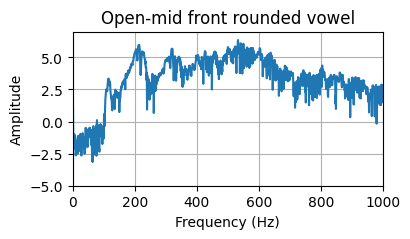

In [16]:
vowel3, srVowel3 = librosa.load("./data/Open-mid_front_rounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel3, sampling_rate=srVowel3, logscale=True)
plt.ylim(-5, 7)
plt.title("Open-mid front rounded vowel")
plt.show()

ipyd.Audio(data=vowel3, rate=srVowel3)

#### From sounds to words

While vowel sounds may be accurately discriminated based on their frequency spectra, even when analysed as a whole, longer sequences of speech (e.g., word, sentences) should be analysed sequentially. For instance, our features should not only capture that an audio sequence consists of frequency spectra corresponding to *a*, *e*, *l*, and *p*, but they should also capture information about order. Otherwise, it would not be possible to discriminate between *leap*, *pale*, *peal*, and *plea*.

### Short-time Fourier transform (STFT)

The STFT determines the frequency content of *local* sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment. Usually, for computing the STFT, the FFT is computed for the first 25 ms of the signal, then for 10-35 ms, then for 20-45 ms. The duration of each *window* is called the window size and the amount with which the window is moves every step is called the *hop length*. Humans are supposed to have a window size of 10 ms. In digital signal processing, 25 ms is chosen because of a rich body of research concluding that 25 ms enable our models to yield the best performance.

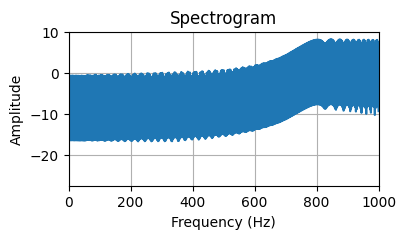

In [17]:
# First, we load an audio for the word spectrogram and inspect it
siren, srSiren= librosa.load("./data/siren.wav", sr=None)

# and for comparison, this is how it looks like when we just compute the FFT
plt = apply_fft(audio=siren, sampling_rate=srSiren, logscale=True)
plt.title("Spectrogram")
plt.show()

ipyd.Audio(data=siren, rate=srSiren)

(0.0, 10000.0)

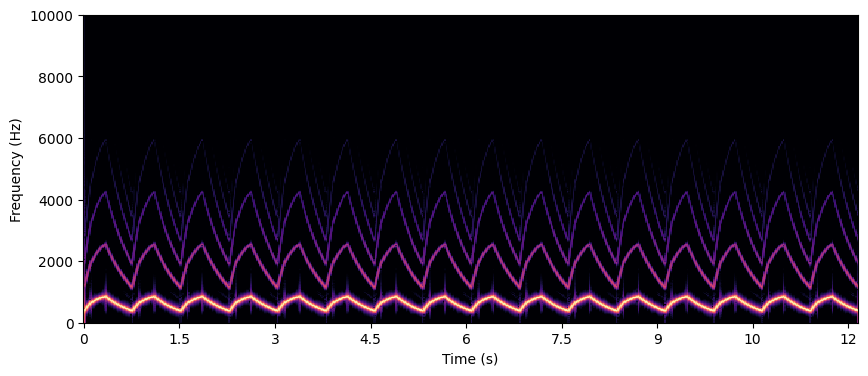

In [18]:
# Luckily, we do not need to implement the spectrogram function from scratch
window_size = int(0.025 * srSiren) # 25ms
hop_length = int(0.010 * srSiren) # 10ms
stft = librosa.stft(siren, n_fft=window_size, hop_length=hop_length)
# Convert to amplitude
stft_amplitude = np.abs(stft)

# plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    librosa.amplitude_to_db(stft_amplitude, ref=np.max),
    x_axis='time', y_axis='hz', ax=ax, fmax=10000
)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 10000])

# TODO:

- create a good looking 3D plot of the spectrogram
- clean up the code 
- ensure that Y-Axis depicts time in ms

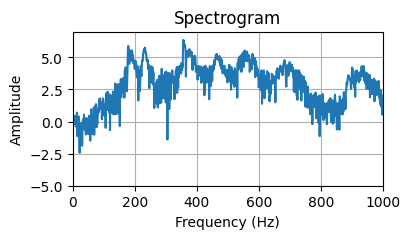

In [19]:
# First, we load an audio for the word spectrogram and inspect it
spectrogram, srSpectrogram = librosa.load("./data/spectrogram.wav", sr=None)

plt = apply_fft(audio=spectrogram, sampling_rate=srSpectrogram, logscale=True)
plt.ylim(-5, 7)
plt.title("Spectrogram")
plt.show()

ipyd.Audio(data=spectrogram, rate=srSpectrogram)

In [20]:
# function for creating a 3D spectrogram
def plot_spectrogram(audio, sampling_rate, log_scale=True, hop_length=50, window_size=50):

    # initialise the first window
    window = [0, window_size]
    while window[1] < len(audio):

        # Create a window of the audio signal
        audio_window = audio[window[0]:window[1]]
    
        # Apply FFT
        w = np.hamming(window_size)
        if log_scale:
            windowFFT = np.log(np.abs(np.fft.fft(audio_window*w)))
        else:
            windowFFT = np.abs(np.fft.fft(audio_window*w))

        # store the FFT result
        if window[0] == 0:
            spectrogram = windowFFT
        else:
            spectrogram = np.vstack((spectrogram, windowFFT))
        window[0] += hop_length
        window[1] += hop_length

    # return the spectrogram
    return spectrogram


window_length = 25
hop_length = 10
test = plot_spectrogram(spectrogram, sampling_rate=srSpectrogram, log_scale=True, hop_length=hop_length, window_size=window_length)

/tmp/ipykernel_3746/1866492520.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # blue to red


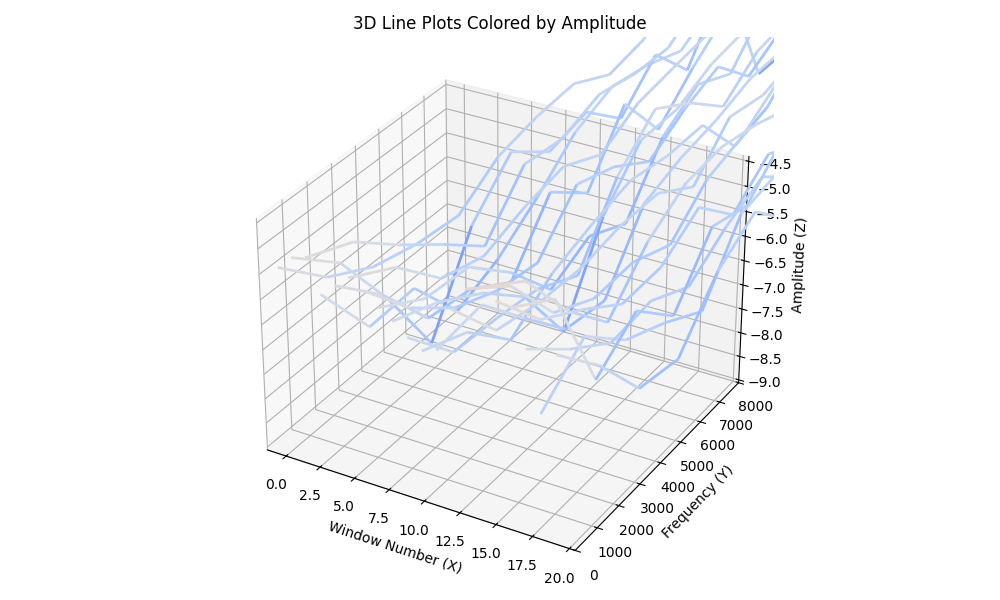

In [21]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

# Flatten the list of vectors into a 1D array
flat = np.concatenate(test)

# Find min and max
lowest = np.min(flat)
highest = np.max(flat)

# Create colormap and normalization
cmap = cm.get_cmap('coolwarm')  # blue to red
norm = Normalize(vmin=lowest, vmax=highest)

# Set up 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Loop through vectors
for idx, vec in enumerate(test[0:20]):
    y = np.linspace(0, srSpectrogram * (window_length - 1) / window_length, window_length)
    x = np.full_like(y, idx)  # Constant x value for each vector
    z = vec

    # Create segments
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Map colors per segment using z values
    values = z[:-1]  # one color per segment (length-1)
    colors = cmap(norm(values))

    # Create and add line collection
    lc = Line3DCollection(segments, colors=colors, linewidth=2)
    ax.add_collection3d(lc)

# Axes labels and limits
ax.set_ylim(0, 8000)
ax.set_xlabel('Window Number (X)')
ax.set_ylabel('Frequency (Y)')
ax.set_zlabel('Amplitude (Z)')
ax.set_title('3D Line Plots Colored by Amplitude')

plt.tight_layout()
plt.show()

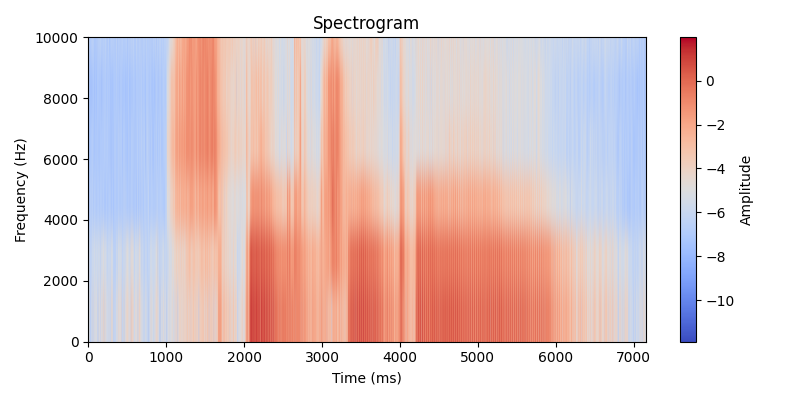

In [22]:
# Convert your list of vectors into a 2D array
# Each row = one time window, each column = frequency bin
amplitudes = np.array(test)  # shape: (time, freq)

plt.figure(figsize=(8, 4))
plt.imshow(
    amplitudes.T,                # transpose so freq on y-axis
    aspect='auto',
    origin='lower',
    cmap='coolwarm',
    extent=[0, amplitudes.shape[0], 0, srSpectrogram * (window_length - 1) / window_length]
)
plt.ylim(0, 10000)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

(0.0, 10000.0)

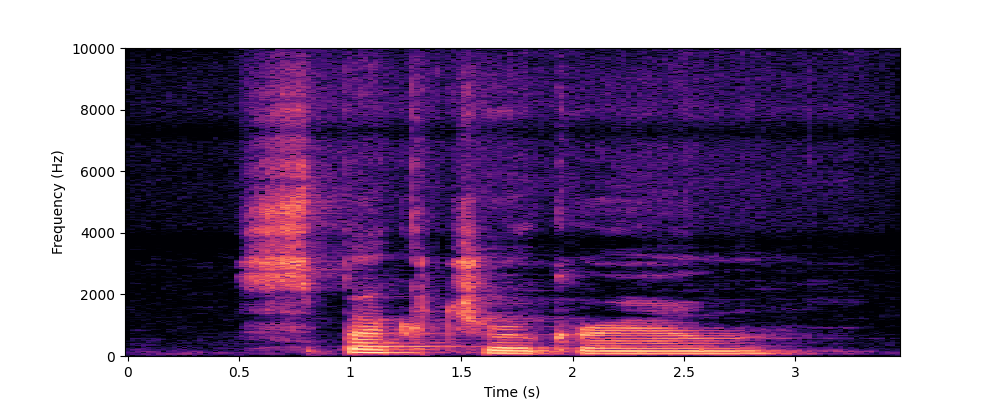

In [23]:
# Luckily, we do not need to implement the spectrogram function from scratch
window_size = int(0.025 * srSpectrogram) # 25ms
hop_length = int(0.010 * srSpectrogram) # 10ms
stft = librosa.stft(spectrogram, n_fft=window_size, hop_length=hop_length)
# Convert to amplitude
stft_amplitude = np.abs(stft)

# plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    librosa.amplitude_to_db(stft_amplitude, ref=np.max),
    x_axis='time', y_axis='hz', ax=ax, fmax=10000
)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 10000])

In [24]:
# Let's have a look at another example
count, srCount= librosa.load("./data/spanish_count.wav")
ipyd.Audio(data=count, rate=srCount)

(0.0, 8000.0)

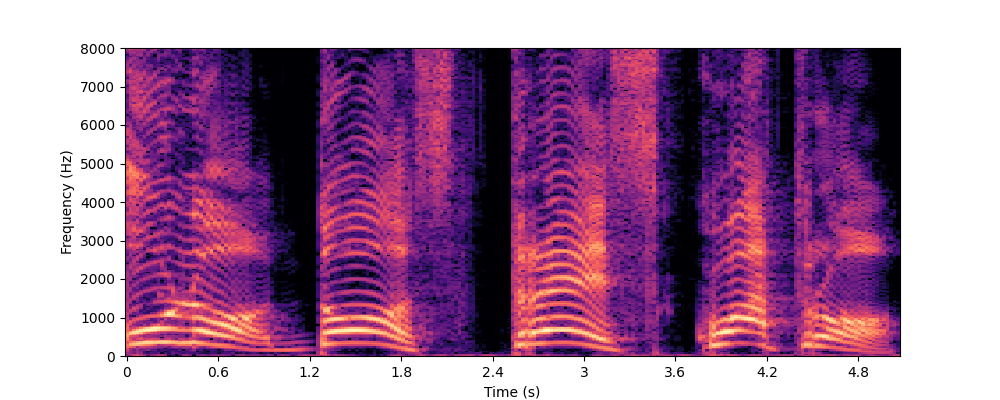

In [25]:
window_size = int(0.025 * srCount) # 25ms
hop_length = int(0.010 * srCount) # 10ms
stft = librosa.stft(count, n_fft=window_size, hop_length=hop_length)

# Convert to amplitude
stft_amplitude = np.abs(stft)

# plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    librosa.amplitude_to_db(stft_amplitude, ref=np.max),
    x_axis='time', y_axis='hz', ax=ax, fmax=8000
)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 8000])

## Mel-scale spectrogram

Human perception is not linear. We're more sensitive to lower than to higher frequencies. For instance, we're more likely to perceive the difference between 300 and 310 Hz than between 3000 and 3010 Hz, which is illustrated by the following block:

In [26]:
sampling_rate = 16000
N = 2*sampling_rate # number of samples for given duration
n = np.arange(N) # sample indices
Hz300 = np.sin(2*np.pi*(300/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz300))
Hz310 = np.sin(2*np.pi*(310/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz310))
Hz2000 = np.sin(2*np.pi*(3000/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz2000))
Hz2010 = np.sin(2*np.pi*(3010/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz2010))

Because we want our model do have the same perception as humans (remember that humans are the most efficient speech recognisers that we know), we want a representation of the audio that emphasises changes in lower frequencies. This is achieved by the Mel-scale spectrogram.

In [27]:
# define functions to transform linear frequencies to mel frequencies and vice versa
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)
def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

The code block below demonstrates the mel scale. While we perceive the sampled sounds on the mel sccale (`mel_scale=True`) as having the same distance, this perception does not emerge when using linear frequencies (`mel_scale=False`).

In [28]:
sampling_rate = 16000
N = 0.5*sampling_rate # number of samples for given duration
n = np.arange(N) # sample indices

# decide which scale we want to use
mel_Scale = True
if mel_Scale:
    aFQ = mel_to_hz(300)
    bFQ = mel_to_hz(400)
    cFQ = mel_to_hz(500)
    dFQ = mel_to_hz(600)
else:
    aFQ = 300
    bFQ = 400
    cFQ = 500
    dFQ = 600

# create samples
aSample = np.sin(2*np.pi*(aFQ/sampling_rate)*n) # generate sine wave
bSample = np.sin(2*np.pi*(bFQ/sampling_rate)*n) # generate sine wave
cSample = np.sin(2*np.pi*(cFQ/sampling_rate)*n) # generate sine wave
dSample = np.sin(2*np.pi*(dFQ/sampling_rate)*n) # generate sine wave

# Combine samples into a single array and repeat three times
combinedSamples = np.tile(np.concatenate([aSample, bSample, cSample, dSample]), 3)
display(ipyd.Audio(rate=sampling_rate, data=combinedSamples))

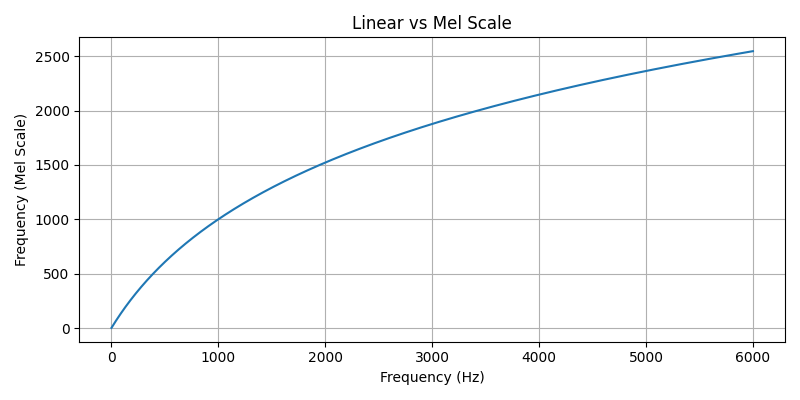

In [29]:
# X-axis: Hz values from 1 to 6000
hz_values = np.arange(1, 6001)  # inclusive range

# Y-axis: Mel values based on the Hz values
mel_values = np.array([hz_to_mel(hz) for hz in hz_values])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(hz_values, mel_values)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency (Mel Scale)")
plt.title("Linear vs Mel Scale")
plt.grid(True)
plt.tight_layout()
plt.show()

# Mel filterbanks

To capture how humans perceive pitch, we use Mel filterbanks, which are a series of overlapping bandpass filters. These filters are applied to the frequency spectrum of an audio signal, whereby each filter emphasises energy in a specific Mel frequency band. Mel frequency bands are distributed according to the Mel scale.


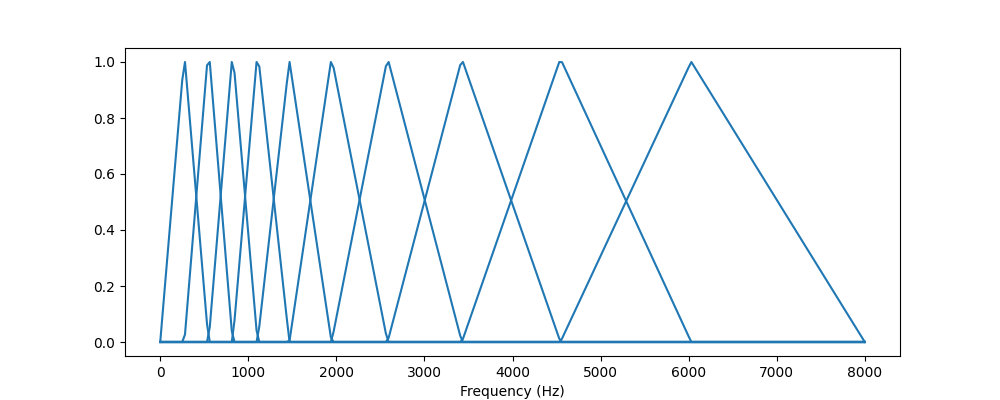

In [40]:
#### Alternative code filterbanks

f_s = 16000
filterbanks = librosa.filters.mel(sr=f_s, n_fft=512, n_mels=10, fmin=0, fmax=8000)
filterbanks /= np.max(filterbanks, axis=-1)[:, None]
f = np.arange(filterbanks.T.shape[0])/512*f_s
plt.figure(figsize=(10, 4))
plt.plot(f, filterbanks.T, "-", c="tab:blue")
plt.xlabel("Frequency (Hz)")
plt.show()

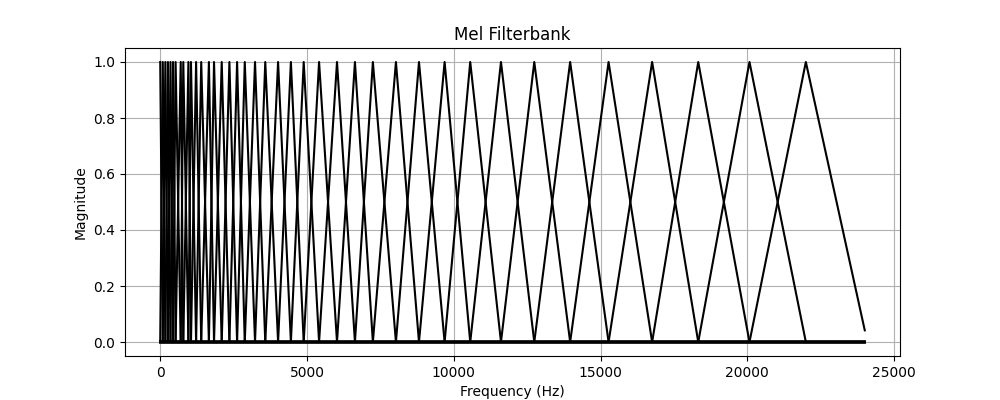

In [30]:
sample_rate = srSpectrogram
n_filters = 40
n_fft = window_size

# Convert the highest frequency to mel scale
high_freq_mel = hz_to_mel(sample_rate / 2)
    
# Create equally spaced points in mel scale
mel_points = np.linspace(0, high_freq_mel, n_filters + 2)
    
# Convert back to Hz
hz_points = mel_to_hz(mel_points)
    
# Convert to FFT bin numbers
bins = np.floor((n_fft + 1) * hz_points / sample_rate)
    
# Create the filterbank matrix
filterbank = np.zeros((n_filters, n_fft // 2 + 1)) 
for i in range(n_filters):
    for j in range(int(bins[i]), int(bins[i + 1])):
        filterbank[i, j] = (j - bins[i]) / (bins[i + 1] - bins[i])
    for j in range(int(bins[i + 1]), int(bins[i + 2])):
        filterbank[i, j] = (bins[i + 2] - j) / (bins[i + 2] - bins[i + 1])
    
# Visualise the filterbank (either for mel or linear scale)
plt.figure(figsize=(10, 4))
freq = np.linspace(0, sample_rate/2, n_fft//2 + 1)
mel_freq = hz_to_mel(freq)

# set scale to use for plotting
mel_Scale = False
if mel_Scale:
    plt_freq = mel_freq
else:
    plt_freq = freq
    
# Plot each filter
for i in range(filterbank.shape[0]):
    plt.plot(plt_freq, filterbank[i], color='black')
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Mel Filterbank')
plt.grid(True)
plt.show()

In [31]:
print(filterbank[0,1:10])
print(filterbank[1,1:10])
print(filterbank[2,1:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


Now we can use this filters to capture the information of our FFT at frequencies corresponding to the mel filter bands. For doing so, for each window of our SFFT, we multiply each filter with this window's FFT and sum up the resulting values.

In [32]:
# get the first window
# window_size = int(0.025 * srSpectrogram) # 25ms
window1 = spectrogram[0:window_size]

# Apply FFT
N = len(window1)
w = np.hamming(N)
window1FFT = np.fft.fft(window1*w)
window1FFTpositives = np.abs(window1FFT[: N//2 + 1]) # keep only the positive frequencies

# multiply first filter with the first window and sum the result
band1 = filterbank[0] * window1FFTpositives
print(f"First filter times first window's FFT {band1[1:5]}")
print(f"Sum of the first filter {np.sum(band1)}")

First filter times first window's FFT [0. 0. 0. 0.]
Sum of the first filter 0.0007803615789336478


In [33]:
# Apply whole mel filterbank to window
mel_spec = filterbank @ window1FFTpositives
mel_spec

array([0.00078036, 0.00892259, 0.03851071, 0.05239393, 0.02625849,
       0.03711997, 0.03276769, 0.01494882, 0.03651579, 0.02698301,
       0.01807609, 0.01049677, 0.01925753, 0.01756384, 0.01147917,
       0.01206026, 0.02320216, 0.02969398, 0.01675904, 0.04167825,
       0.02348457, 0.02550672, 0.02208552, 0.01851125, 0.02802976,
       0.02954214, 0.01251347, 0.0304708 , 0.02148303, 0.04593265,
       0.06973286, 0.05717249, 0.09644346, 0.11390547, 0.1465631 ,
       0.11129931, 0.12111122, 0.1880608 , 0.22337559, 0.11970265])

In [34]:
np.linspace(1, filterbank.shape[0], filterbank.shape[0])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40.])

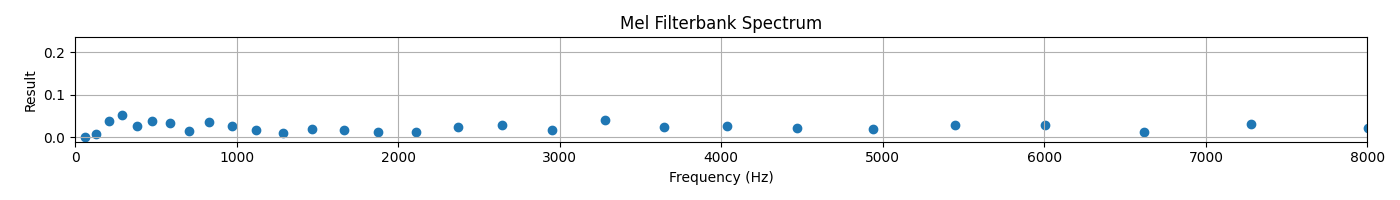

In [35]:
# visualise the filtered signal
mel_frequencies = hz_points[1:-1]  # shape: (n_filters,)

plt.figure(figsize=(14, 2))
plt.scatter(mel_frequencies, mel_spec)
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 8000)
plt.ylabel("Result")
plt.title("Mel Filterbank Spectrum")
plt.grid(True)
plt.tight_layout()
plt.show()

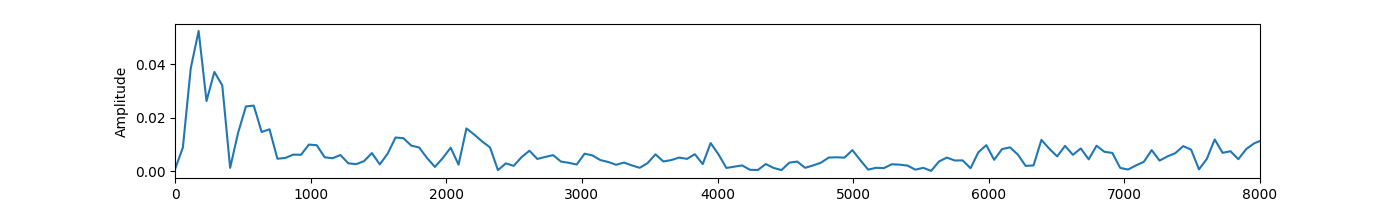

In [36]:
# comapre to the original FFT
plt.figure(figsize=(14, 2))
plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N//2 + 1), window1FFTpositives)
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 8000)
plt.ylabel('Amplitude')
plt.show()

### Comparison spectrogram vs. log-Mel spectrogram

/tmp/ipykernel_3746/3550006379.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 4))


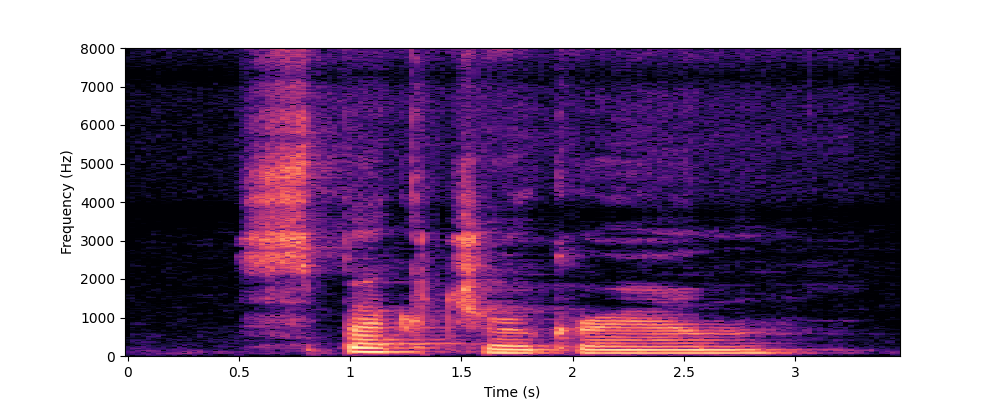

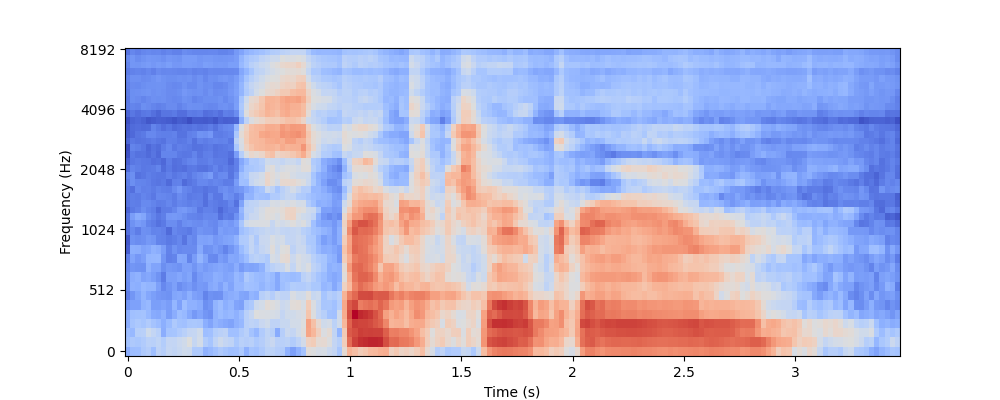

In [50]:
window_size = int(0.025 * srSpectrogram) # 25ms
hop_length = int(0.010 * srSpectrogram) # 10ms
stft = librosa.stft(spectrogram, n_fft=window_size, hop_length=hop_length)

# Convert to amplitude
stft_amplitude = np.abs(stft)

# plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    librosa.amplitude_to_db(stft_amplitude, ref=np.max),
    x_axis='time', y_axis='hz', ax=ax, fmax=8000
)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 8000])
plt.show()

# Mel-scale spectrogram
mel_spectrogram = librosa.feature.melspectrogram(
    y=spectrogram/1.0, sr=srSpectrogram, n_mels=40, n_fft=window_size, hop_length=hop_length
)
log_mel_spectrogram = np.log(mel_spectrogram)

# plot log-mel spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    log_mel_spectrogram, x_axis='time', y_axis='mel', ax=ax, fmax=8000
)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

Note that y-axis scale on log-Mel scale Spectrogram is on log scale and not linear.

## Mel-Frequency Cepstral Coefficient (MFCC)

Mel-Frequency Cepstral Coefficients (MFCCs) are a compact representation of the spectral properties of audio, which is derived by first converting the audio signal into a log Mel-scale spectrogram. Further compressing and decorrelating with a Discrete Cosine Transform (DCT) is applied across the Mel filterbank energies in each time frame. This concentrates the most relevant information into the first few coefficients, reducing redundancy and dimensionality. MFCCs are particularly useful in traditional machine learning pipelines, such as Hidden Markov Models (HMMs), where lower-dimensional, decorrelated features can improve model efficiency and performance compared to raw or log Mel-spectrograms.

Text(0.5, 0, 'Time (s)')

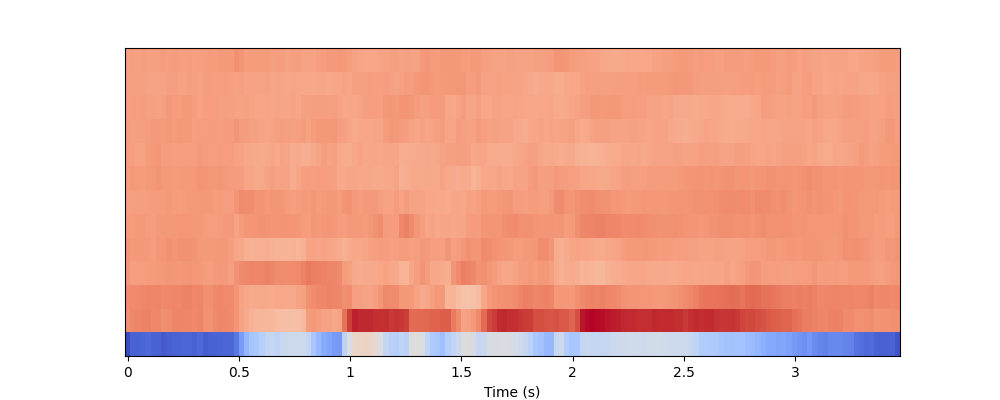

In [58]:
# Mel-scale spectrogram
mfccs = librosa.feature.mfcc(
    y=spectrogram/1.0, sr=srSpectrogram, n_mfcc=13, n_mels=40, n_fft=window_size, hop_length=hop_length
)

# plot log-mel spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    mfccs, x_axis='time'
)
plt.xlabel('Time (s)')

## Summary

Using the mel filterbank allows for the representation of each window using a vector with as many dimensions as the number of filters used. In summary, using mel filterbanks have multiple advantages:

- Emphasis of pitch differences for lower frequencies (more filters for lower frequencies than for higher frequencies)
- Reduction of features (typically 40 to 80 features for each windows instead of more than thousand frequency bins of raw FFTs)
- Increased noise robustness because of averaging FFT magnitudes over frequency bands so that local noise is smoothed out

In the literature, you will often read about Mel-Frequency Cepstral Coefficients (MFCCs), which are basically the Mel-Frequency Coefficients that we just computed.

- to-do check color scheme
- finalise blocks